In [1]:
!pip install datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.4 MB/s eta 0:00:00


In [4]:
import random
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from datasets import load_dataset, DatasetDict, Dataset
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, auc, confusion_matrix
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
import huggingface_hub
huggingface_hub.login()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
from transformers import set_seed
SEED = 0
set_seed(SEED)

# Deterministic behavior (may slow training)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
torch.use_deterministic_algorithms(True)


seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
def load_split_from_serialized(path, valid_size = 0.1, test_size = 0.1, seed=0):
    """
    Loads a serialized CSV file and splits it into training, validation, and test sets.

    Args:
        path (str): Path to the serialized CSV file (must include 'text', 'label', etc.).
        valid_size (float): Proportion of the dataset to include in the validation split.
        test_size (float): Proportion of the dataset to include in the test split.
        seed (int): Random seed for reproducibility.

    Returns:
        DatasetDict with 'train', 'validation', and 'test' datasets.
    """
    df = pd.read_csv(path)

    if "text" not in df.columns or "label" not in df.columns:
        raise ValueError("CSV file must contain 'text' and 'label' columns.")

    # First split: separate test set from the rest
    train_val_df, test_df = train_test_split(df, test_size=test_size, stratify=df["label"], random_state=seed, shuffle=True)

    # Calculate the proportion of validation set relative to the combined train+val set
    # For example, if valid_size=0.1 and train_size=0.8, then valid_ratio_in_train_val = 0.1 / (0.8 + 0.1) = 0.1 / 0.9 = 1/9
    valid_ratio_in_train_val = valid_size / (1.0 - test_size)

    # Second split: separate validation set from the training set
    train_df, valid_df = train_test_split(train_val_df, test_size=valid_ratio_in_train_val, stratify=train_val_df["label"], random_state=seed, shuffle=True)

    return DatasetDict({
        "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
        "validation": Dataset.from_pandas(valid_df.reset_index(drop=True)),
        "test": Dataset.from_pandas(test_df.reset_index(drop=True))
    })

In [7]:
accuracy = evaluate.load("accuracy")


def compute_metrics(eval_pred):
   predictions, labels = eval_pred
   #predictions = np.argmax(predictions[0], axis=1)
   predictions = np.argmax(predictions, axis=-1) # for roberta?

   return accuracy.compute(predictions=predictions, references=labels)

# Training The Model via 80/20 Random Split Strategie

## Choosing the DataSet

In [87]:
data_path = "/content/roundrobin_conservation.csv"

## Choosing the LLM

In [88]:
model_id = "roberta-base"

## Split the data

In [89]:
imdb = load_split_from_serialized(data_path)

In [90]:
print(imdb)

DatasetDict({
    train: Dataset({
        features: ['genome_id', 'gene1', 'gene2', 'text', 'label'],
        num_rows: 6783
    })
    validation: Dataset({
        features: ['genome_id', 'gene1', 'gene2', 'text', 'label'],
        num_rows: 848
    })
    test: Dataset({
        features: ['genome_id', 'gene1', 'gene2', 'text', 'label'],
        num_rows: 848
    })
})


In [91]:
tokenizer = AutoTokenizer.from_pretrained(model_id,device_map = 'auto')
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
classifier.out_proj.bias        | MISSING    | 
classifier.dense.bias           | MISSING    | 
classifier.dense.weight         | MISSING    | 
classifier.out_proj.weight      | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [92]:
if torch.cuda.is_available() and torch.cuda.device_count() > 1:
    device = torch.device("cuda:0")
    model.to(device)

In [93]:
def preprocess_function(examples):
   return tokenizer(examples["text"])

In [94]:
tokenized_imdb = imdb.map(preprocess_function, batched=True)

Map:   0%|          | 0/6783 [00:00<?, ? examples/s]

Map:   0%|          | 0/848 [00:00<?, ? examples/s]

Map:   0%|          | 0/848 [00:00<?, ? examples/s]

In [95]:
training_args = TrainingArguments(
   output_dir="operons_conservation",
   learning_rate=3e-5,
   per_device_train_batch_size=32,
   per_device_eval_batch_size=32,
   num_train_epochs=10,
   weight_decay=0.01, # 0001
   lr_scheduler_type= "linear", # polynomial
   seed=0,
   data_seed=0,

   load_best_model_at_end=True,
   metric_for_best_model = "accuracy",
   eval_strategy='epoch',
   save_strategy='epoch'
)

In [96]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, max_length= 2048)

In [97]:
trainer = Trainer(
   model = model,
   args=training_args,
   train_dataset=tokenized_imdb["train"],
   eval_dataset=tokenized_imdb["validation"],
   data_collator=data_collator,
   compute_metrics=compute_metrics
)

In [98]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.414759,0.841981
2,No log,0.405361,0.826651
3,0.416886,0.400673,0.837264
4,0.416886,0.375383,0.838443
5,0.361025,0.384605,0.840802
6,0.361025,0.377693,0.836085
7,0.361025,0.385706,0.833726
8,0.345963,0.376215,0.834906
9,0.345963,0.389154,0.833726
10,0.327508,0.393638,0.834906


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.bias', 'roberta.encoder.layer.3.output.LayerNorm.weight', 'roberta.encoder.layer.3.output.Laye

TrainOutput(global_step=2120, training_loss=0.3605721239773732, metrics={'train_runtime': 215.6461, 'train_samples_per_second': 314.543, 'train_steps_per_second': 9.831, 'total_flos': 2237561164767720.0, 'train_loss': 0.3605721239773732, 'epoch': 10.0})

In [99]:
trainer.evaluate()

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


{'eval_loss': 0.4142387807369232,
 'eval_accuracy': 0.8419811320754716,
 'eval_runtime': 0.8986,
 'eval_samples_per_second': 943.693,
 'eval_steps_per_second': 30.047,
 'epoch': 10.0}

In [100]:
trainer.push_to_hub()

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...rvation/model.safetensors:   0%|          |  556kB /  499MB            

  ...rvation/training_args.bin:   2%|1         |  98.0B / 5.20kB            

CommitInfo(commit_url='https://huggingface.co/bif02/operons_conservation/commit/a14faf6ae74432fae22b551835154f232d9577bc', commit_message='End of training', commit_description='', oid='a14faf6ae74432fae22b551835154f232d9577bc', pr_url=None, repo_url=RepoUrl('https://huggingface.co/bif02/operons_conservation', endpoint='https://huggingface.co', repo_type='model', repo_id='bif02/operons_conservation'), pr_revision=None, pr_num=None)

## Testing on 10% of the dataset

In [101]:
# Reload accuracy metric to ensure it's not a float from previous runs
accuracy = evaluate.load("accuracy")

ppredictions_ = trainer.predict(test_dataset=tokenized_imdb["test"])
llabels_ = ppredictions_.label_ids
# Unpack logits from predictions
llogits_ = ppredictions_.predictions[0] if isinstance(ppredictions_.predictions, tuple) else ppredictions_.predictions
ppreds_ = np.argmax(llogits_, axis=-1)

# Sensitivity
sensitivity_ = recall_score(llabels_, ppreds_)

# Specificity
tn, fp, fn, tp = confusion_matrix(llabels_, ppreds_).ravel()
specificity_ = tn / (tn + fp)

# Precision
precision_f = tp/(tp+fp)

# PR_AUC
precision_, recall_, thresholds_ = precision_recall_curve(llabels_, ppreds_)

# 2. Calculate the area under those points
pr_auc_ = auc(recall_, precision_)
calculated_accuracy_ = (tp+tn)/(tp+fp+tn+fn) # Renamed to avoid collision with global 'accuracy' object
f1_score_ = (2*sensitivity_*precision_f)/(sensitivity_+precision_f)
print("Sensitivity:", sensitivity_)
print("Specificity:", specificity_)
print("accuracy:", calculated_accuracy_) # Print the renamed variable
print("f1-score:", f1_score_)
print("PR_AUC:",pr_auc_ )

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:2402: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Sensitivity: 0.8259860788863109
Specificity: 0.8633093525179856
accuracy: 0.8443396226415094
f1-score: 0.8436018957345973
PR_AUC: 0.8882074736338449


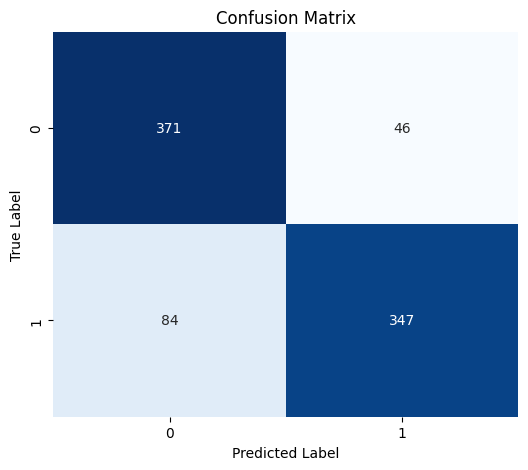

In [24]:

# Plot Confusion Matrix
cm = confusion_matrix(llabels_, ppreds_)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()